# Written by Federica B. Bianco @fedhere
# for NYU CUSP PUI2016
# This is my example of Assignment 2, Phase 1 and 2.
# For Assignment 2 you should design your own investigation into the citibike data.
- # Come up with a question about the Citibike data usage. It can be anything that involves Categorical data. 
    # At this point of the class it is easier to run tests of proportions or similar, and work with categorical data. Categorical cn be anhything that can be punt into classes (e.g. day/night, male/female, 2014/2015/2016.... as long as you set up your experiment the proper way!)
- # Choose the significance threshold
- # Clearly state they Null and Alternate hypothesis
- # Wrangle the data so that it is ready for your analysis.

In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os

%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

import os
import json
s = json.load( open(os.getenv('PUI2016') + "/fbb_matplotlibrc.json") )
pl.rcParams.update(s)


Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# IDEA:
## Women are less likely than men to choose biking _for commuting_

# NULL HYPOTHESIS:
## The ratio of man biking on week days to man biking on weekends is _the same_ or _higher_  than the ratio of woman biking on week days to woman biking on weekends

# _$H_0$_ : $\frac{W_{\mathrm{weekend}}}{W_{\mathrm{week}}} <= \frac{M_{\mathrm{weekend}}}{M_{\mathrm{week}}}$
# _$H_1$_ : $\frac{W_{\mathrm{weekend}}}{W_{\mathrm{week}}} > \frac{M_{\mathrm{weekend}}}{M_{\mathrm{week}}}$


## I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

# I am starting with a singl month of data: 
## reading data from citibike csv file from Jan 2015

what I want is the date and time of the beginning of each trip. pandas has an easy method to read csv files, and an easy method to convert strinds to dates.

if i read a csv file with pandas the content is stored in a "DataFrame". You can think of it as a python dictionary in many ways,but it has many added capabilities: it is easy to convert variables within it, it knows how to plot itself, etc.

### download and move  data to PUIDATA


In [22]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system


def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
                os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [4]:
df=pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00


In [5]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'date'],
      dtype='object')

In [6]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)

In [7]:
df.head()

,gender,date
0,2,2015-01-01 00:01:00
1,1,2015-01-01 00:02:00
2,1,2015-01-01 00:04:00
3,1,2015-01-01 00:04:00
4,1,2015-01-01 00:05:00


# lets separate males (_m) from females (_w) to test various hypothesis 
# in this csv file gender == 1 is male, gender == 2 is female

# lets plot the number of trips per week day

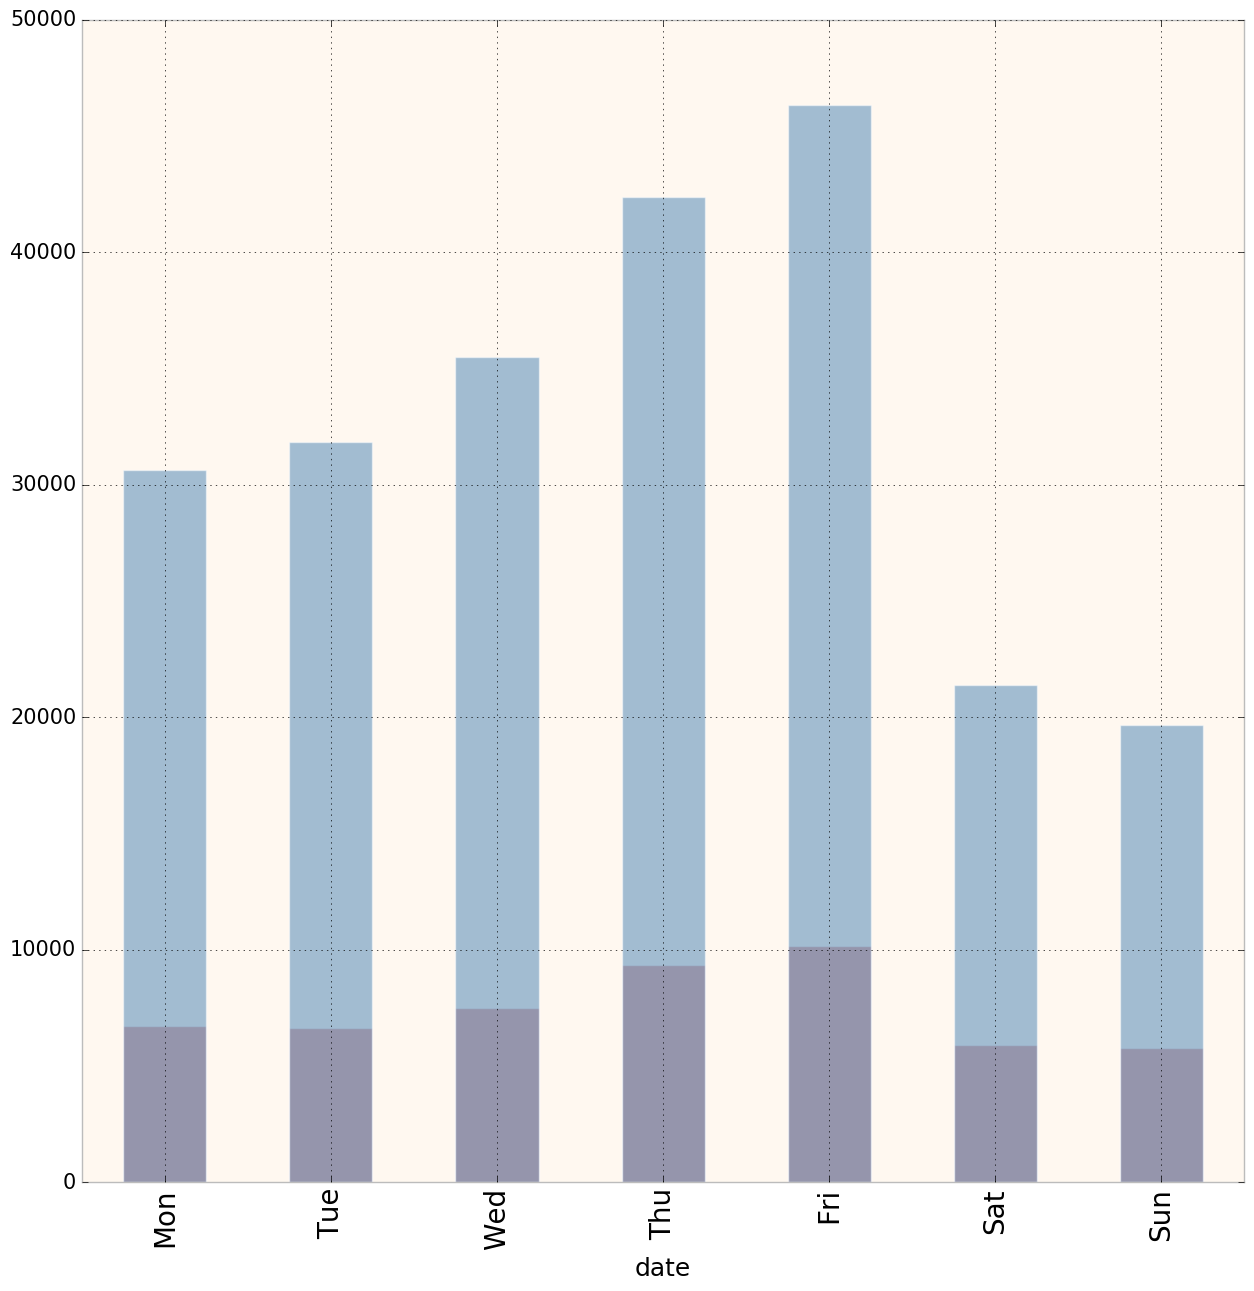

In [8]:
fig=pl.figure(figsize(15,15))

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_w = 1
((df['date'][df['gender'] == 2].groupby([df['date'].dt.weekday]).count()) / norm_w).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         alpha=0.5)

norm_m = 1
ax = ((df['date'][df['gender'] == 1].groupby([df['date'].dt.weekday]).count()) / norm_m).plot(kind="bar", 
                                                                                              alpha=0.5)

tmp = ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)

Note: the counts have errors of course. what is the error on the count statistics? 
for N counts the error is sqrt(N) - this is because counts follow a Poisson statistic

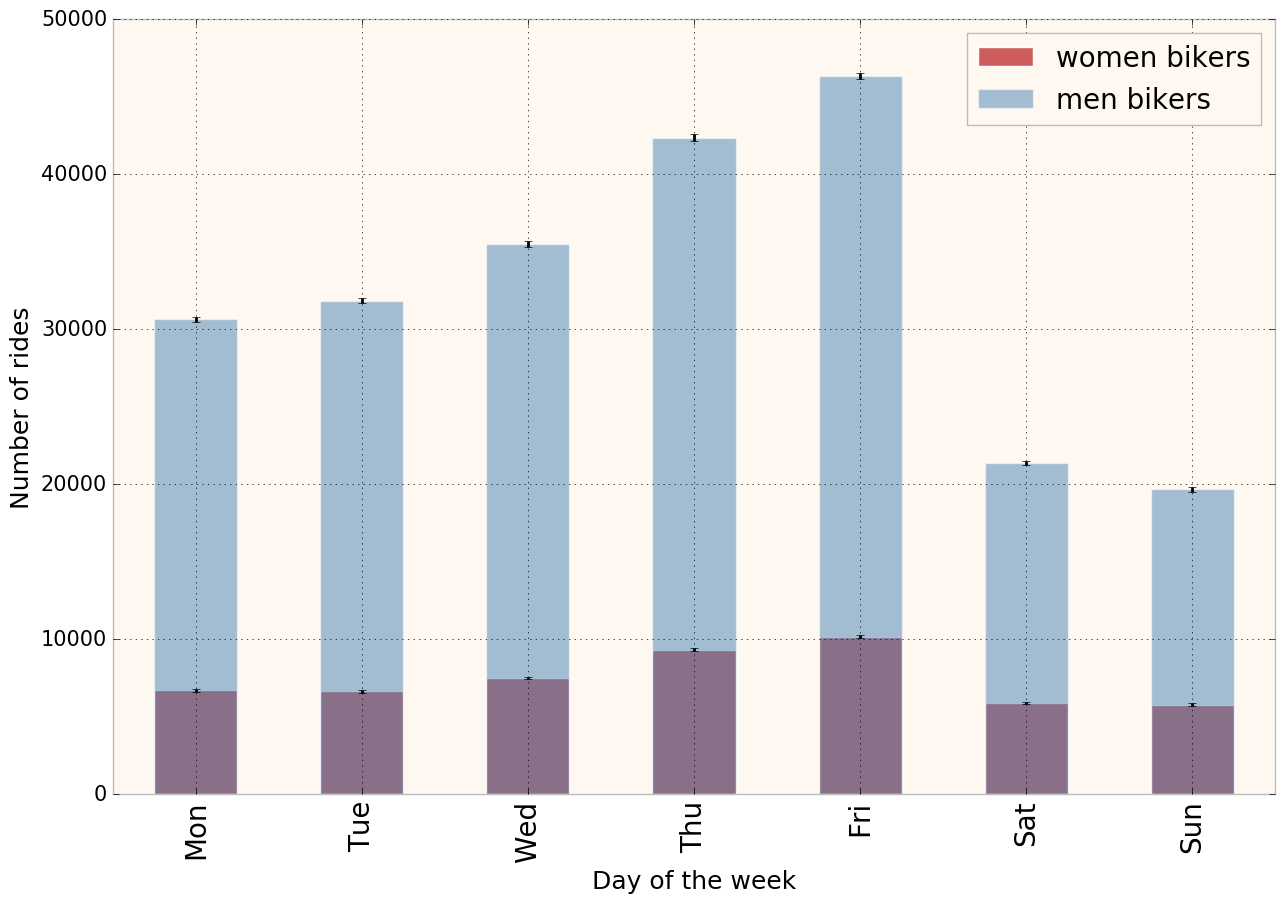

In [9]:
fig=pl.figure(figsize(15,10))

counts_w = df.date[df.gender == 2].groupby([df.date.dt.weekday]).count()
norm_w = 1
error_w = np.sqrt(counts_w)
ax=((counts_w) / norm_w).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w) / norm_w, (error_w) / norm_w)], label='women bikers')


counts_m = df.date[df.gender==1].groupby([df.date.dt.weekday]).count()
norm_m = 1
error_m=np.sqrt(counts_m)
((counts_m) / norm_m).plot(kind="bar", alpha=0.5, yerr=[((error_m) / norm_m, (error_m) / norm_m)], label='men bikers')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Day of the week")
pl.legend(['women bikers','men bikers'],fontsize=20)


## Figure 1: Distribution of Citibike bikers by gender in January 2014, absolute counts

Note: These are absolute numbers. It is very hard to compare absolute numbers. Ratios (or proportions) are more ameable to comparison, so let's _normalize_ the distribution of man, and that of women (i.e. devide them by the total number of rides for that gender. Notice that i have to normalize the errorbars too!)



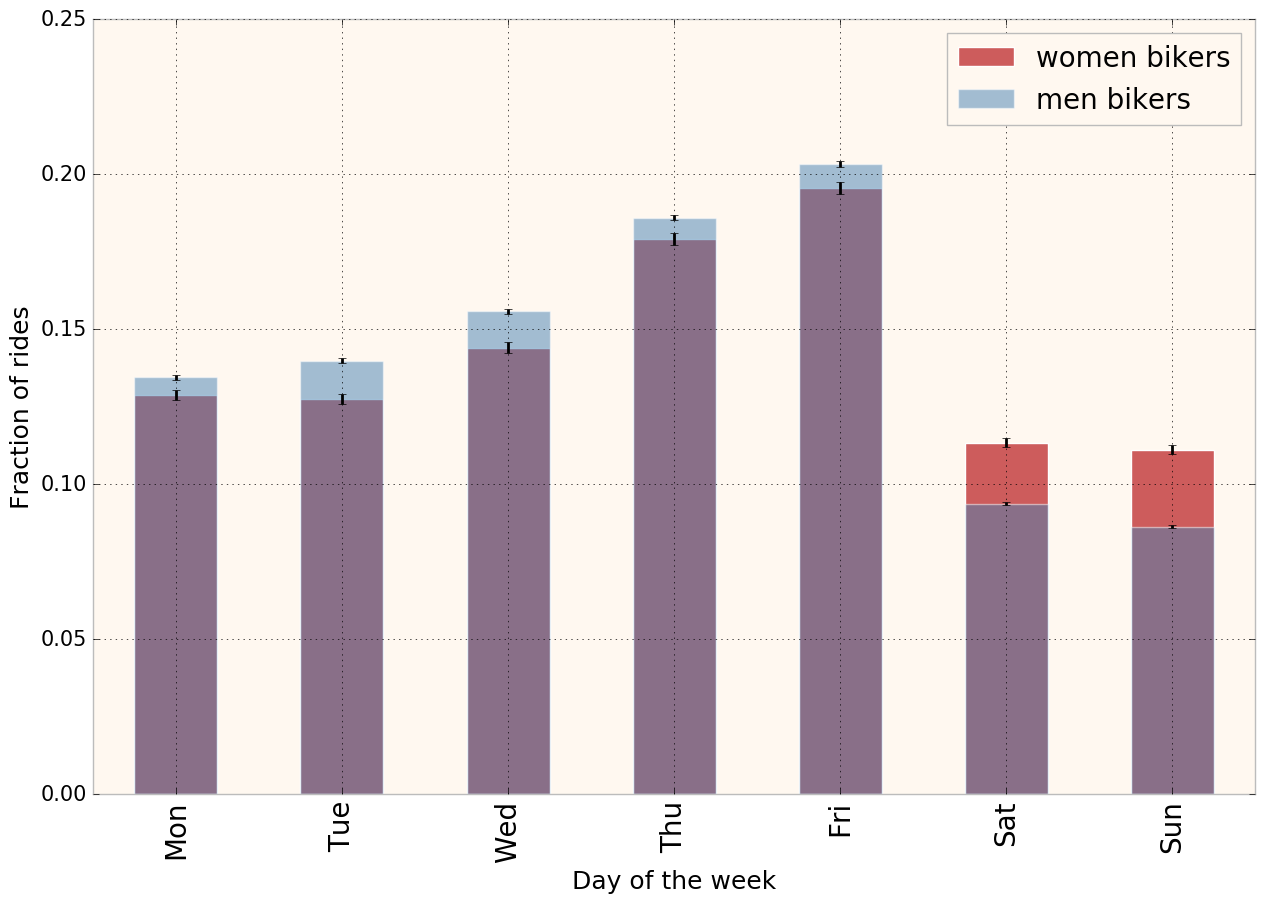

In [10]:
fig = pl.figure(figsize(15,10))

norm_w = counts_w.sum()
error_w = np.sqrt(counts_w)
((counts_w) / norm_w).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w) / norm_w, (error_w) / norm_w)], label='women bikers')

norm_m = counts_m.sum()
ax = ((counts_m) / norm_m).plot(kind="bar", alpha=0.5, yerr=[((error_m)/norm_m,(error_m)/norm_m)], label='men bikers')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day of the week")

pl.legend(['women bikers','men bikers'],fontsize=20)


## Figure 2: Distribution of Citibike bikers by gender in January 2014, normalized

we can add up the week and weekend days, then this becomes a test of proportions, like the one seen in the employment notebook

## Set up the test of proportions

Men: week:0.820, weekend:0.180, weekend error:0.002, weekend error:0.001
Women: week:0.775, weekend:0.225, weekend error:0.004, weekend error:0.002


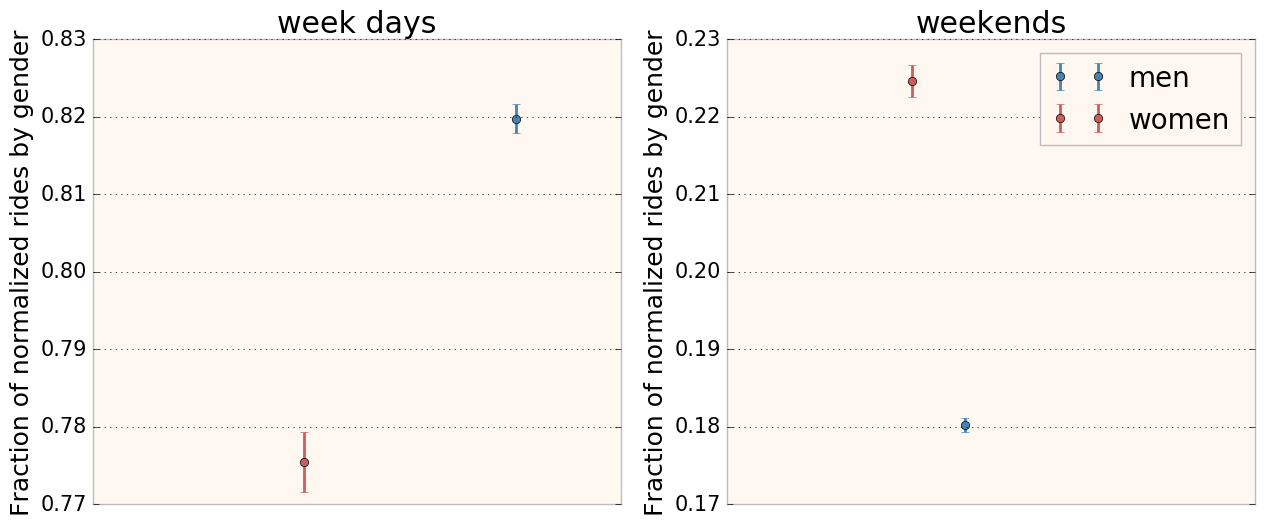

In [11]:
fig = pl.figure(figsize(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])
week_w = sum(counts_w[:-2]) * 1.0 / norm_w
weekend_w = sum(counts_w[-2:]) * 1.0 / norm_w
eweek_w = np.sqrt(sum(error_w[:-2]**2)) / norm_w
eweekend_w = np.sqrt(sum(error_w[-2:]**2)) / norm_w

week_m = sum(counts_m[:-2]) * 1.0 / norm_m
weekend_m = sum(counts_m[-2:]) * 1.0 / norm_m
eweek_m = np.sqrt(sum(error_m[:-2]**2)) / norm_m
eweekend_m = np.sqrt(sum(error_m[-2:]**2)) / norm_m

print("Men: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_m, weekend_m, eweek_m, eweekend_m))
print("Women: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_w, weekend_w, eweek_w, eweekend_w))

ax1.errorbar([0.4], [week_m], yerr=[eweek_m], fmt='o', label='men')
ax1.errorbar([0.2], [week_w], yerr=[eweek_w], fmt='o', label='women')
ax1.set_xlim(0, 0.5)
ax2.errorbar([0.4], [weekend_m], yerr=[eweekend_m], fmt='o', label='men')
ax2.errorbar([0.2], [weekend_w], yerr=[eweekend_w], fmt='o', label='women')
ax1.set_xlim(0, 0.5)
ax1.set_title("week days")
ax2.set_title("weekends")
ax2.set_ylabel("Fraction of normalized rides by gender")
ax1.set_ylabel("Fraction of normalized rides by gender")

pl.xlim(-0.5, 1.5)
pl.legend(fontsize = 20)

# This is the portion of Assignment 2 that should be done by the week of September 26. 
# The rest will be due the following week.

In [12]:
p = (week_w * norm_w + week_m * norm_m) * 1.0 / (norm_w + norm_m)
SE = np.sqrt(p * ( 1. - p ) * ( (1. / norm_w) + (1. / norm_m) ) )
z = (week_w - week_m ) / SE
print(p, SE, z)

0.811514452024 0.00189942880377 -23.3360245689


## Figure 3: Fraction of Citibike bikers per gender in January 2016 for week days (left) and weekends (right)

### Is the percentage of women that ride on weekends lower or equal to that of man?

In [13]:
P0mP1 = weekend_m - weekend_w
print ("difference between man and women on weekend: ", P0mP1)

difference between man and women on weekend:  -0.0443251172318


### Is this difference statistically significant?

In [14]:
sp_stdev= lambda p0, n1: np.sqrt(p0*(1-p0)/n1)
sp_stdev_mw=sp_stdev(weekend_w,norm_m)

zscore = lambda p0, p1, s : (p0-p1)/s
z = zscore(weekend_w, weekend_m, sp_stdev_mw)
print (z) 



50.693489576


## The largest number i see in the z stats table in assignment 1 is 2.9, which gives me a p value
## <0.0002, which is smaller then my chosen $\alpha=0.05$ - so yes, it is statistically significant!
### Notice that this statistical significance was obvious in the plot: the distance between the error bars, which represent 1 standard deviation, is larger than a factor 2, i.e. if I inflate each error bar by a factor 2 they still do not overlap, which means I am more significant then 2  standard deviations : p<0.05

# Lets see if our test holds in the summer, when outfits are more ameable to riding

In [15]:
datestring = '201506'
getCitiBikeCSV(datestring)

file in place, you can continue


In [16]:
df_06 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df_06['date'] = pd.to_datetime(df_06.starttime)

In [17]:
df_06.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984.0,1,2015-06-01 00:00:00
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997.0,1,2015-06-01 00:00:00
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993.0,1,2015-06-01 00:01:00
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981.0,1,2015-06-01 00:01:00
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0,2015-06-01 00:02:00


In [18]:
df_06.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)


In [19]:
df_06.head()

,gender,date
0,1,2015-06-01 00:00:00
1,1,2015-06-01 00:00:00
2,1,2015-06-01 00:01:00
3,1,2015-06-01 00:01:00
4,0,2015-06-01 00:02:00


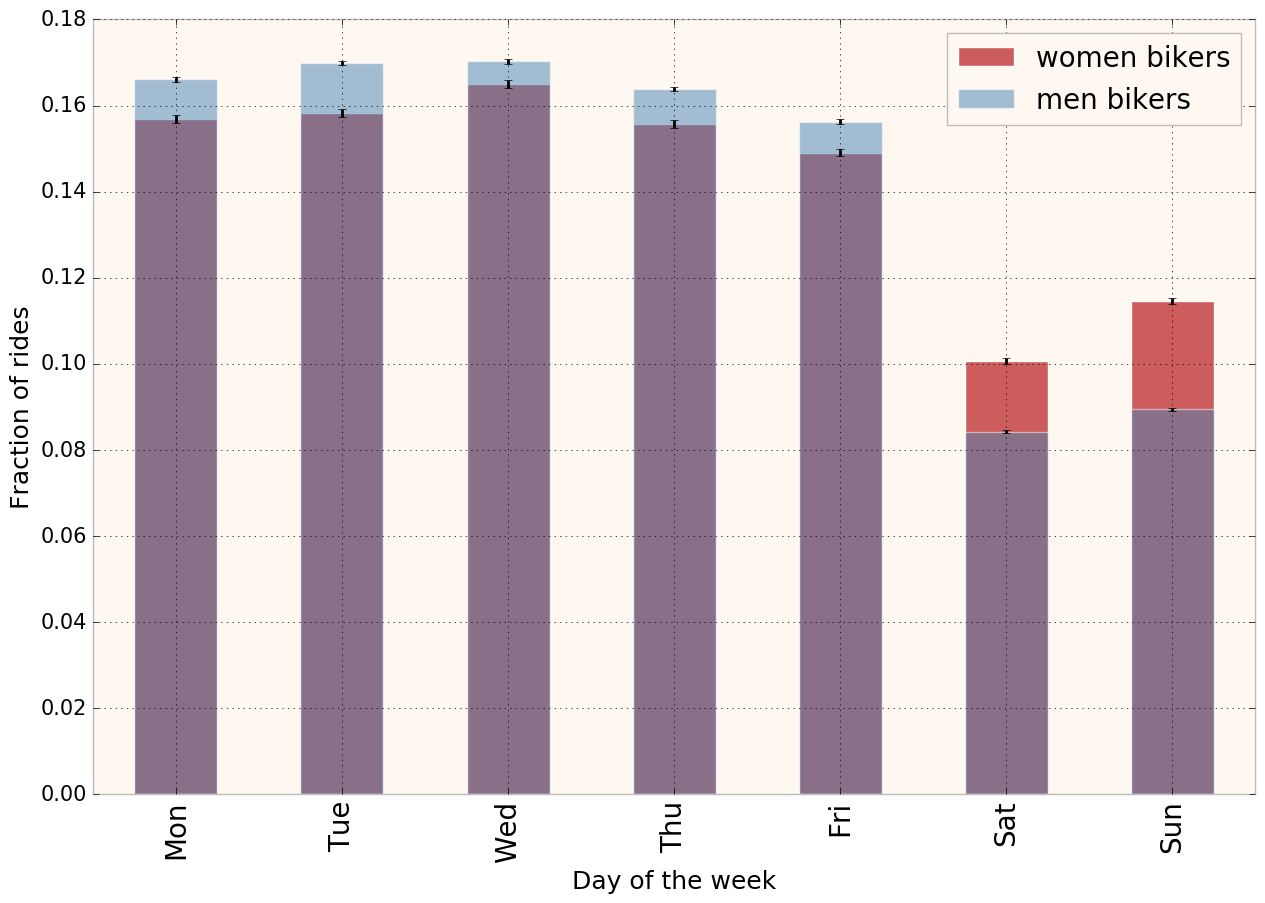

In [20]:
fig=pl.figure(figsize(15,10))

counts_w06 = df_06.date[df_06.gender == 2].groupby([df_06.date.dt.weekday]).count()
norm_w06 = counts_w06.sum()
error_w06 = np.sqrt(counts_w06)

((counts_w06) / norm_w06).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w06) / norm_w06,(error_w06) / norm_w06)], label='women bikers, June')

counts_m06 = df_06.date[df_06.gender==1].groupby([df_06.date.dt.weekday]).count()
norm_m06 = counts_m06.sum()
error_m06 = np.sqrt(counts_m06)
ax=((counts_m06) / norm_m06).plot(kind="bar", alpha=0.5, yerr=[((error_m06)/norm_m06,(error_m06)/norm_m06)], 
                                  label='men bikers, June')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day of the week")


pl.legend(['women bikers','men bikers'],fontsize=20)

## Figure 4: Distribution of Citibike bikers by gender in June 2016, normalized

Men: week:0.826, weekend:0.174, weekend error:0.001, weekend error:0.001
Women: week:0.785, weekend:0.215, weekend error:0.002, weekend error:0.001
0.816637169452 0.00101716674446 -40.8636171831


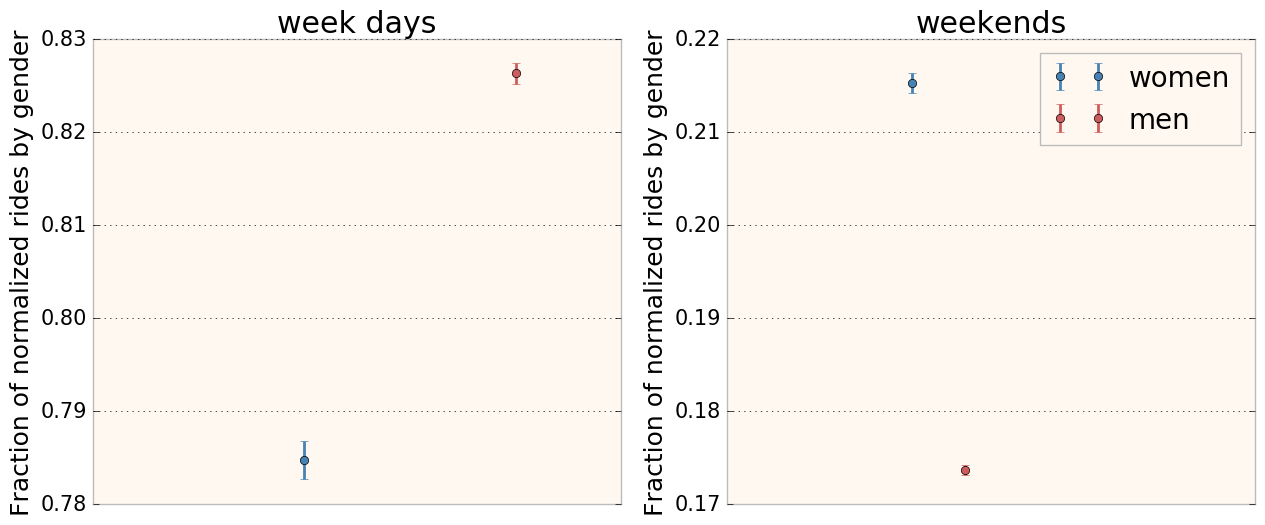

In [21]:
fig=pl.figure(figsize(15,6))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])
week_w = sum(counts_w06[:-2])*1.0/norm_w06
weekend_w = sum(counts_w06[-2:])*1.0/norm_w06
eweek_w = np.sqrt(sum(error_w06[:-2]**2))/norm_w06
eweekend_w = np.sqrt(sum(error_w06[-2:]**2))/norm_w06

week_m = sum(counts_m06[:-2])*1.0/norm_m06
weekend_m = sum(counts_m06[-2:])*1.0/norm_m06
eweek_m = np.sqrt(sum(error_m06[:-2]**2))/norm_m06
eweekend_m = np.sqrt(sum(error_m06[-2:]**2))/norm_m06

print("Men: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_m, weekend_m, eweek_m, eweekend_m))
print("Women: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_w, weekend_w, eweek_w, eweekend_w))

ax1.errorbar([0.2],[week_w], yerr=[eweek_w], fmt='o', label='women')
ax1.errorbar([0.4],[week_m], yerr=[eweek_m], fmt='o', label='men')
ax1.set_xlim(0,0.5)
ax2.errorbar([0.2],[weekend_w], yerr=[eweekend_w], fmt='o', label='women')
ax2.errorbar([0.4],[weekend_m], yerr=[eweekend_m], fmt='o', label='men')
ax1.set_xlim(0,0.5)
ax1.set_title("week days")
ax2.set_title("weekends")
ax2.set_ylabel("Fraction of normalized rides by gender")
ax1.set_ylabel("Fraction of normalized rides by gender")

pl.xlim(-0.5,1.5)
pl.legend(fontsize=20)

p = (week_w*norm_w06 + week_m*norm_m06)*1.0/ (norm_w06 + norm_m06)
SE = np.sqrt(p * ( 1. - p ) * ( (1./norm_w06) + (1./norm_m06) ) )
z = (week_w - week_m ) / SE
print(p, SE, z)

# i do not need to run a test statistics even: the 1 sigma error bars overlap. my result is not robust once i use a larger, more diverse dataset